In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pandas.plotting import table
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn import tree
from sklearn import metrics

%matplotlib inline
sns.set(color_codes=True)

# Training XGBoost Model

In [2]:
# trainTextExtract.json.zip is the latest version of training data!!
trainCleaned = "dataset/two-sigma-connect-rental-listing-inquiries/trainTextExtract.json.zip"
trainData = pd.read_json(trainCleaned, convert_dates=['created'])
# processed testData
testDataDir = "dataset/two-sigma-connect-rental-listing-inquiries/testTextExtract.json.zip"
testData = pd.read_json(testDataDir, convert_dates=['created'])

In [3]:
trainData.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address', 'grayscale_hist', 'avg_pixel_values', 'num_photos',
       'desc_word_count', 'desc_char_count', 'desc_avg_word_length',
       'desc_special_char_count', 'desc_num_count', 'desc_upper_count',
       'num_features', 'year', 'month', 'day'],
      dtype='object')

## Choosing features for prediction

The features listed should be necessary for prediction <br/>
- Bathrooms<br/>
Reason: Interest levels depends on the number of bathrooms a listing has  
- Bedrooms<br/>
Reason: Interest levels depends on the number of bedrooms a listing has
- Price <br/>
Reason: Interest levels depends on the listing price
- Year, Month, Date<br/>
Reason: if the user is planning to move out to another location within a specific time frame, interest may be higher
- Description Word Count (desc_word_count)<br/>
Reason: descriptions with more words could mean very detailed description which lead to higher interest
- Description Average Word Length(desc_avg_word_length)<br/>
Reason: large average word length could mean very detailed description which lead to higher interest
- Number of features (num_features)<br/>
Reason: more features within a listing could lead to more interest
- Latitude + Longitude <br/>
Reason: interest could be higher on specific area of New York

In [8]:
featuresToSelect = ['bathrooms', 'bedrooms', 'price', 'year', 'month', 'day', 'desc_word_count', 'desc_avg_word_length', 'num_features', 'latitude', 'longitude', 'num_photos']
X = trainData[featuresToSelect]
testX = testData[featuresToSelect]
X.head(5)

,bathrooms,bedrooms,price,year,month,day,desc_word_count,desc_avg_word_length,num_features,latitude,longitude,num_photos
0,2.0,3,3050,2016,6,24,183,6.044199,8,40.6678,-73.9398,8
1,2.0,3,3100,2016,4,29,44,7.477273,0,40.6678,-73.9398,10
2,1.0,1,2850,2016,6,17,32,6.225806,3,40.7287,-73.9810,3
3,1.0,3,4200,2016,6,8,62,5.393443,3,40.7287,-73.9810,6
4,1.0,1,2850,2016,6,11,134,4.684211,3,40.7287,-73.9810,4


## Transform target variable to binary codes
References: <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html


In [9]:
#This works also:
#target = trainData[['interest_level']].astype('category')
#y = target['interest_level'].cat.codes
le=LabelEncoder()
target = trainData[['interest_level']]
y = le.fit_transform(target['interest_level'])
y

array([1, 1, 1, ..., 2, 2, 0])

## Creating XGB Model
Library used for classifier: sklearn.tree.DecisionTreeClassifier <br/>
Note for log loss score: log_loss_score > 1 <=> prediction is inaccurate/wrong <br/>
References: <br/>
https://markhneedham.com/blog/2016/09/14/scikit-learn-first-steps-with-log_loss/ <br/>
https://rpmcruz.github.io/machine%20learning/2018/02/09/probabilities-trees.html <br/>
https://stackoverflow.com/questions/33616102/sklearn-log-loss-different-number-of-classes/42953278 <br/>
https://towardsdatascience.com/train-val-split-and-cross-validation-in-python-80b61beca4b6

### Original
Training: Evaluate model using log loss <br/>
Testing: Output prediction probabilities for test dataset <br/>
All parameters of the model should have its default values for initialization

In [33]:
model = xgb.XGBClassifier()
acc_scores = []
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(X, y):
    train_X, val_X = X.iloc[train_index,:], X.iloc[val_index,:]
    train_y, val_y = y[train_index], y[val_index]
    model.fit(train_X, train_y)
    val_y_pred = model.predict_proba(val_X)
    score = metrics.log_loss(val_y, val_y_pred)
    acc_scores.append(score)
print(np.mean(acc_scores))

0.6984858881744934


In [34]:
preds = model.predict_proba(testX)
out_df = pd.DataFrame(preds)
out_df.columns = le.classes_
out_df["listing_id"] = testData.listing_id.values
out_df

,high,low,medium,listing_id
0,0.087866,0.487050,0.425083,7142618
1,0.297210,0.370430,0.332360,7210040
2,0.116790,0.546299,0.336911,7174566
3,0.389089,0.222792,0.388120,7191391
4,0.014250,0.888996,0.096754,7171695
...,...,...,...,...
74654,0.322781,0.478013,0.199205,6928108
74655,0.035355,0.722697,0.241948,6906674
74656,0.045509,0.684757,0.269734,6897967
74657,0.000754,0.975588,0.023658,6842183


In [35]:
out_df.to_csv("XGBOriginal.csv", index=False)

## Detecting overfitting with original model
Since <b>max_depth</b>, <b>min_child_weight</b> and <b>Gamma</b> all controls overfiting, we can adjust the parameters accordingly to monitor how overfitting occurs <br/> <br/>
Method: Compute accuracy score for training and validation set for <b>max_depth</b>, <b>min_child_weight</b> and <b>Gamma</b>, then plot it <br/>
If accuracy of validation is significantly lower than training accuracy and validation is decreasing as the parameters increase -> overfit <br/>
https://datascience.stackexchange.com/questions/9758/overfitting-underfitting-with-data-set-size/9760#9760 <br/>

[]

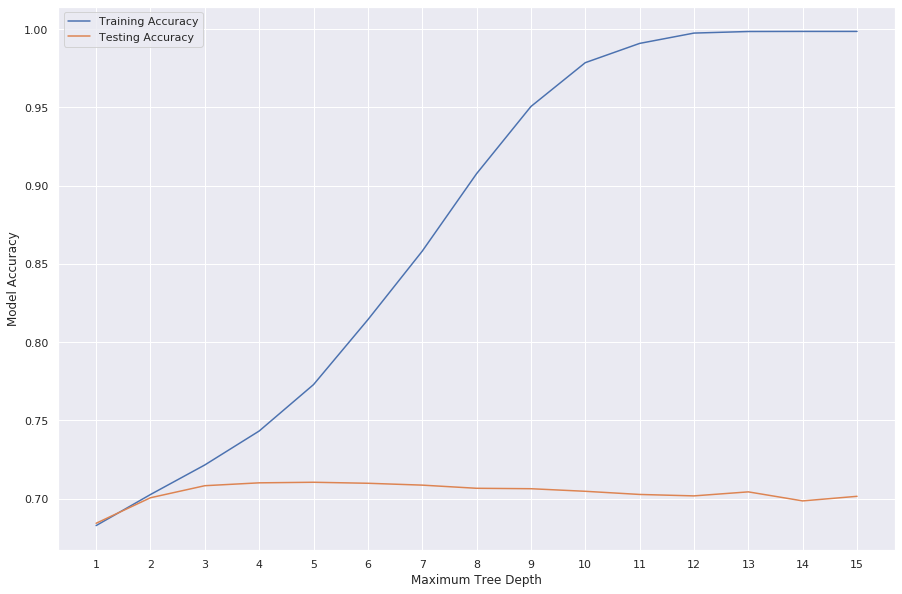

In [20]:
max_depth_list = np.linspace(1,15, num=15)

train_accuracy = [] # Log training errors for each model
test_accuracy = [] # Log testing errors for each model

X_train, X_test, y_train, y_test = train_test_split(X, y)

for x in max_depth_list:
    model = xgb.XGBClassifier(max_depth=int(x)) 
    model.fit(X_train,y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))

x = np.arange(len(max_depth_list)) + 1 # Create domain for plot
plt.figure(figsize=(15,10))
plt.xticks(x)
plt.plot(x, train_accuracy, label='Training Accuracy') # Plot training error over domain
plt.plot(x, test_accuracy, label='Testing Accuracy') # Plot testing error over domain
plt.xlabel('Maximum Tree Depth') # Label x-axis
plt.ylabel('Model Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.plot() # Show graph

[]

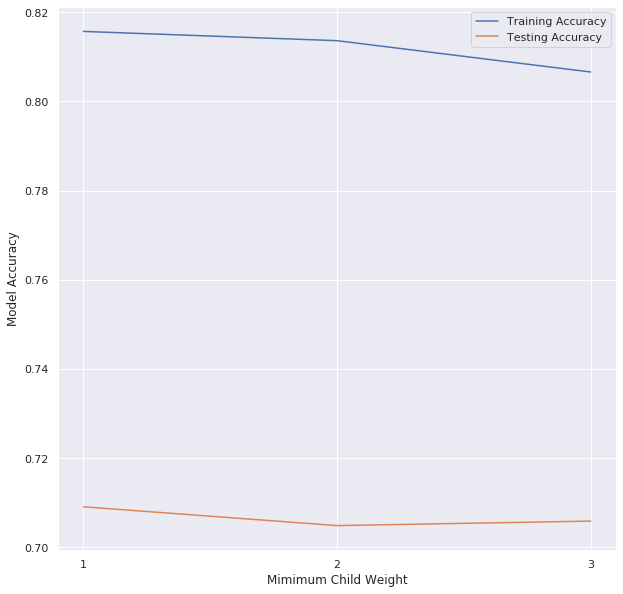

In [19]:
min_child_weight_list = range(1,6,2)

train_accuracy = [] # Log training errors for each model
test_accuracy = [] # Log testing errors for each model

X_train, X_test, y_train, y_test = train_test_split(X, y)

for x in min_child_weight_list:
    model = xgb.XGBClassifier(min_child_weight=int(x)) 
    model.fit(X_train,y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))

x = np.arange(len(min_child_weight_list)) + 1 # Create domain for plot
plt.figure(figsize=(10,10))
plt.xticks(x)
plt.plot(x, train_accuracy, label='Training Accuracy') # Plot training error over domain
plt.plot(x, test_accuracy, label='Testing Accuracy') # Plot testing error over domain
plt.xlabel('Mimimum Child Weight') # Label x-axis
plt.ylabel('Model Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.plot() # Show graph

[]

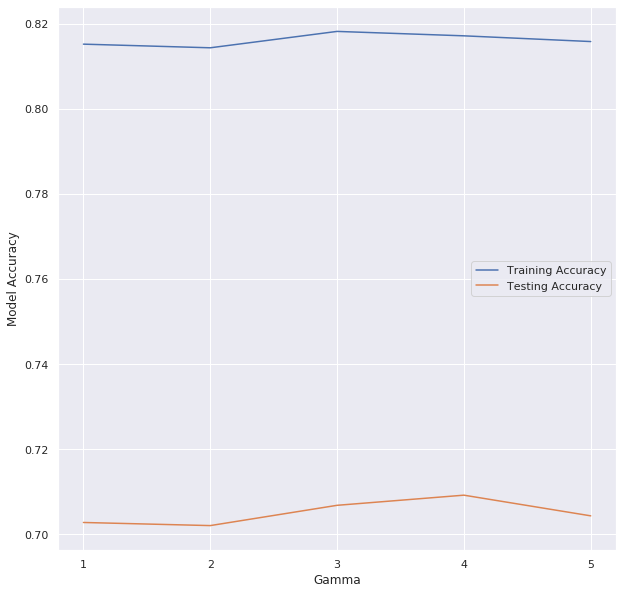

In [22]:
gamma_list = [i/10.0 for i in range(0,5)]

train_accuracy = [] # Log training errors for each model
test_accuracy = [] # Log testing errors for each model

X_train, X_test, y_train, y_test = train_test_split(X, y)

for x in gamma_list:
    model = xgb.XGBClassifier(gamma=x) 
    model.fit(X_train,y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))

x = np.arange(len(gamma_list)) + 1 # Create domain for plot
plt.figure(figsize=(10,10))
plt.xticks(x)
plt.plot(x, train_accuracy, label='Training Accuracy') # Plot training error over domain
plt.plot(x, test_accuracy, label='Testing Accuracy') # Plot testing error over domain
plt.xlabel('Gamma') # Label x-axis
plt.ylabel('Model Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.plot() # Show graph

## Improving XGB Model
Side Note: 5-fold should generate enough instances to validate the model due to large number of records

Using RandomizedSearchCV for cv = 5 <br/>
Randomized Search is more efficient on larger dataset while still yield the top accuracy<br/>
References: <br/>
https://stackoverflow.com/questions/33616102/sklearn-log-loss-different-number-of-classes/42953278 <br/>
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ <br/>
https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e <br/>
https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6

### Tuning parameters 

<b>max_depth</b>: <br/>
Controls over-fitting. Higher depth will allow model to learn relations very specific to a particular sample. <br/>
<b>min_child_weight</b>: <br/>
Controls over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can lead to under-fitting <br/>
<b> gamma </b>: <br/>
Used to control over-fitting (Regularization). <br/>
The higher Gamma is, the higher the regularization.<br/>
Gamma values around 20 are extremely high, and should be used only when you are using high depth <br/>
These add randomness to make training robust to noise. <br/>
<b>subsample</b>: <br/>
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. <br/>
<b>colsample_bytree</b>: <br/>
Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature. <br/>

### First version
Initialization parameters: <br/>
- max_depth = 5 (This should be between 3-10)
- min_child_weight = 1 (A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups)
- gamma = 0 (A smaller value like 0.1-0.2 can also be chosen for starting)
- subsample, colsample_bytree = 0.8 (Commonly used used start value. Typical values range between 0.5-0.9)
- scale_pos_weight = 1 Because of high class imbalance. 
- n_estimators = 500 (The number of boosting stages to perform)
- learning_rate = 0.1 (Default)
- kf = 5 (number of cross-validation fold)
<br/> <br/>
Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [17]:
model = xgb.XGBClassifier(
    max_depth = 5, 
    min_child_weight = 1, 
    gamma = 0, 
    subsample = 0.8, 
    colsample_bytree = 0.8, 
    scale_pos_weight = 1, 
    n_estimators = 500,
    learning_rate = 0.1,
)
acc_scores = []
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(X, y):
    train_X, val_X = X.iloc[train_index,:], X.iloc[val_index,:]
    train_y, val_y = y[train_index], y[val_index]
    model.fit(train_X, train_y)
    val_y_pred = model.predict_proba(val_X)
    score = metrics.log_loss(val_y, val_y_pred)
    acc_scores.append(score)
print(np.mean(acc_scores))

0.6823520617633618


In [18]:
preds = model.predict_proba(testX)
out_df = pd.DataFrame(preds)
out_df.columns = le.classes_
out_df["listing_id"] = testData.listing_id.values
out_df

,high,low,medium,listing_id
0,0.070656,0.345480,0.583865,7142618
1,0.240441,0.413085,0.346474,7210040
2,0.036275,0.764979,0.198745,7174566
3,0.473826,0.220453,0.305721,7191391
4,0.013830,0.876480,0.109690,7171695
...,...,...,...,...
74654,0.392084,0.310571,0.297345,6928108
74655,0.018034,0.749481,0.232486,6906674
74656,0.000800,0.985486,0.013714,6897967
74657,0.002454,0.962136,0.035410,6842183


In [19]:
out_df.to_csv("XGBFirstVers.csv", index=False)

### Second version
Using the initialized parameters for tuning

In [10]:
grid_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'gamma' : [i for i in range(0,5)],
    'subsample' : [i/10.0 for i in range(3,8)],
    'colsample_bytree' : [i/10.0 for i in range(6,10)]
}
kf = StratifiedKFold(n_splits=5)
model = xgb.XGBClassifier(
    max_depth = 5, 
    min_child_weight = 1, 
    gamma = 0, 
    subsample = 0.8, 
    colsample_bytree = 0.8, 
    scale_pos_weight = 1, 
    n_estimators = 500,
    learning_rate = 0.1,
)
grid_object = RandomizedSearchCV(estimator = model, param_distributions = grid_params, scoring = 'neg_log_loss', cv = kf, n_jobs = -1,return_train_score = True)

In [11]:
grid_object.fit(X,y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.8, gamma=0,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.1,
                                           max_delta_step=None, max_dep...
                                           validate_parameters=False,
                                           verbosity=None),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                 

In [12]:
grid_object.best_params_

{'subsample': 0.7,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 2,
 'colsample_bytree': 0.9}

In [13]:
grid_object.best_score_

-0.6803757787435246

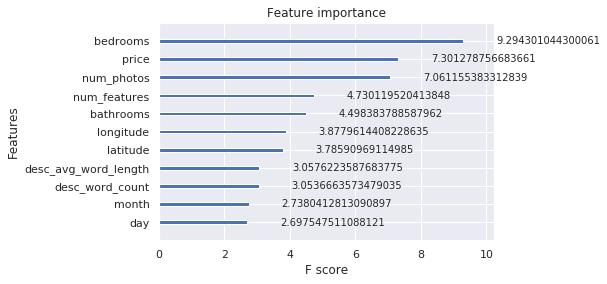

In [14]:
xgb.plot_importance(grid_object.best_estimator_, importance_type="gain")

In [15]:
preds = grid_object.predict_proba(testX)
out_df = pd.DataFrame(preds)
out_df.columns = le.classes_
out_df["listing_id"] = testData.listing_id.values
out_df

,high,low,medium,listing_id
0,0.092483,0.361319,0.546199,7142618
1,0.243865,0.368333,0.387801,7210040
2,0.033932,0.745431,0.220637,7174566
3,0.426805,0.211619,0.361576,7191391
4,0.010416,0.863166,0.126417,7171695
...,...,...,...,...
74654,0.451419,0.270596,0.277985,6928108
74655,0.022291,0.746020,0.231690,6906674
74656,0.002034,0.967080,0.030886,6897967
74657,0.001078,0.967939,0.030982,6842183


In [16]:
out_df.to_csv("XGBSecondVers-All.csv", index=False)

## Additional Metrics for validation dataset
Accuracy Score: the model accuracy is determined by comparing how many of the predicted labels matches with the true labels
Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

In [13]:
model = xgb.XGBClassifier(
    max_depth = 5,
    subsample = 0.7,
    min_child_weight = 5,
    gamma = 0.1,
    colsample_bytree = 0.8
)
kf = StratifiedKFold(n_splits=5)
acc_scores = []
for train_index, val_index in kf.split(X, y):
    train_X, val_X = X.iloc[train_index,:], X.iloc[val_index,:]
    train_y, val_y = y[train_index], y[val_index]
    model.fit(train_X, train_y)
    val_y_pred = model.predict(val_X)
    score = metrics.accuracy_score(val_y, val_y_pred)
    acc_scores.append(score)
print(np.mean(acc_scores))

0.6795301907871536
